This nb uses LSI with a 2D embedding space and visualizes gender within the embedding.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

import genre_data_loader

# import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

# import re

# import os
# from gensim import corpora
# from gensim.corpora import MmCorpus
# from gensim.models import TfidfModel, LsiModel
# from gensim.matutils import corpus2dense

# import json

seed = 23

In [55]:
# get currrent date for latest version of data set
%store -r now

X_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

# call data loader script for training data
genre_data = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train,
                                                  X_path_test = X_path_test, y_path_test = y_path_test)
# call it for train data
genre_data_train = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train)
# call it for test data
genre_data_test = genre_data_loader.LoadGenreData(now, X_path_train = X_path_test, y_path_train = y_path_test)

# load data with genre sets
data_train = genre_data_train.as_strings()
data_train = genre_data_train.as_lists()
data_train = genre_data_train.as_sets()
data_balanced = genre_data_train.get_balanced_sample()

data_test = genre_data_test.as_strings()

data = genre_data.as_strings()
data = genre_data.as_sets()

# create list of all genres
list_of_genres = genre_data.get_list_of_genres()

# Create a dictionary of {genre : genre_id}
dict_gid = genre_data.get_dict_genre_to_id()
dict_idg = genre_data.get_dict_id_to_genre()

In [56]:
data_train.shape, data_test.shape, data.shape

((12376, 5), (3094, 3), (15470, 4))

### Introduce sparse -> tfidf -> truncated svd (LSI)

In [57]:
def transform_to_svd(data):

    vec = CountVectorizer(vocabulary = dict_gid) # uses scipy.sparse.csr_matrix representation
    # create sparse matrix of training features NOTE: cannot use .get_sparse_matrix() method of genre_data_loader:
    # that will use a dict_gid built from the list of genres only from training data 
    
    # fit and transform
    X = vec.fit_transform(data.genre_string)

    tfidf_transformer = TfidfTransformer()
    X = tfidf_transformer.fit_transform(X)
    svd_transformer = TruncatedSVD(n_components = 2)
    svd_transformer.fit(X)
    X = svd_transformer.transform(X)
    
    # Encode Labels with UDF so can control encoding:
    def encode_targets(row):
        if row.gender == 'female':
            return 1
        else:
            return 0

    y = data.apply(encode_targets, axis = 1)
    y = y.values
    
    # transformers
    bow_transform = vec.transform
    tfidf_transform = tfidf_transformer.transform
    svd_transform = svd_transformer.transform
    
    return X, y, bow_transform, tfidf_transform, svd_transform

In [58]:
X_train, y_train, bow_transform, tfidf_transform, svd_transform = transform_to_svd(data_train)
# X_bal, y_bal, bow_transform, tfidf_transform, svd_transform = transform_to_svd(data_balanced)
def full_transform(document):
    return svd_transform(tfidf_transform(bow_transform(document)))

In [59]:
# full_transform(data_train.genre_string.iloc[0:3])

Test alignment of data, X, y

From genre_data_loader.ipynb:

In [60]:
# def decode_sparse_list(X_sparse, row_number):
#     zeros, cols = X_sparse[row_number].nonzero()
#     cols_labels = [dict_idg[ind] for ind in cols]
#     cols_labels.sort()
#     return cols_labels

### Check alignment of data_train and (X_train, y_train)

In [61]:
# n = np.random.randint(data_balanced.shape[0])
# sorted(decode_sparse_list(X, n)), sorted(data_balanced.genre_list.iloc[n])
# n = np.random.randint(data_balanced.shape[0])
# y[n], data_balanced.gender.iloc[n]

Visualize gender within embedding:

In [62]:
targets = pd.DataFrame({'GenderCode':y_train})

In [63]:
def color_map(row):
    if row.GenderCode == 1:
        return 'Orange'
    else:
        return 'Blue'

In [64]:
targets['Colors'] = targets.apply(color_map, axis = 1)

In [65]:
targets_male = targets[targets.GenderCode == 0]
targets_female = targets[targets.GenderCode == 1]
X_male = X_train[targets_male.index]
X_female = X_train[targets_female.index]

Plot embedding:

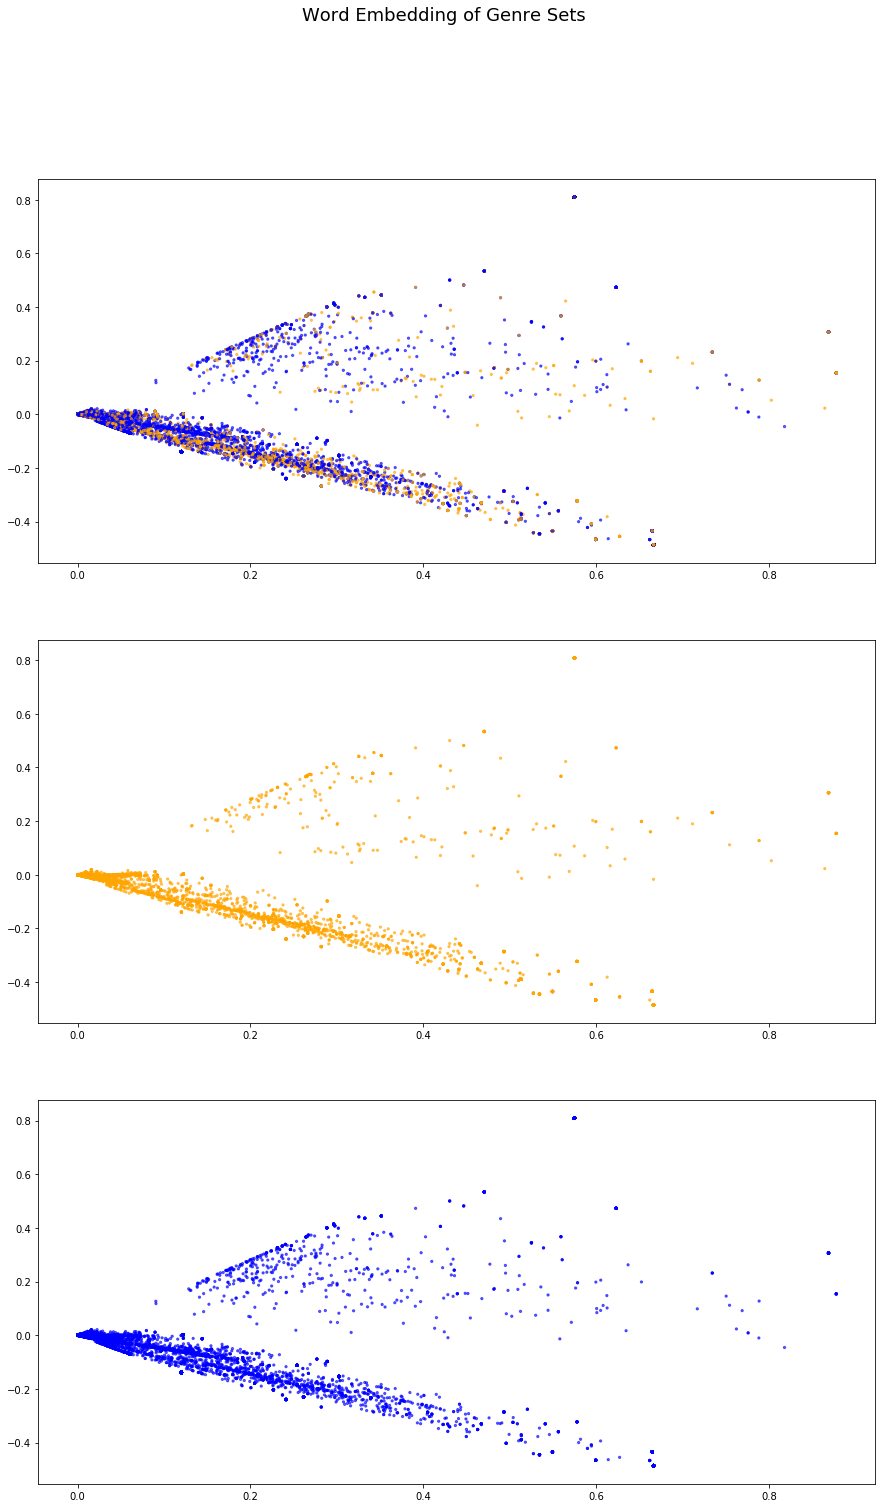

In [66]:
fig, axs = plt.subplots(3, figsize = (15,24))
fig.suptitle('Word Embedding of Genre Sets', fontsize = 18)
axs[0].scatter(X_train[:,0], X_train[:,1], c= targets.Colors.values, s = 5, alpha = .6)
axs[1].scatter(X_female[:,0], X_female[:,1], c= targets_female.Colors.values, s = 5, alpha = .6)
axs[2].scatter(X_male[:,0], X_male[:,1], c= targets_male.Colors.values, s = 5, alpha = .6)
# for i in range(10):
#     ax.annotate(lsi_df.iloc[i,2],(lsi_df.iloc[i,0],lsi_df.iloc[i,1]), fontsize = 52)
# ax.hlines(0, -.6,.5)
# ax.vlines(0, -.6,.6)
#plt.show()

The above embedding does not distinguish male or female.

- [ ] could apply k-means and then measure correlation of clusters with gender